# EE5907 CA2 Face Recognition
> by SS47816

## 0. Load Dataset

In [2]:
import os
import random
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def readImageData(data_path, set='train', num_PIE_imgs=-1):
    
    # List all subjects in set
    set_path = os.path.join(data_path, set)
    subject_paths = os.listdir(set_path)

    # Within each subject of the PIE dataset, read all images
    PIE_imgs = []
    my_imgs = []
    for subject_path in subject_paths:
        folder_path = os.path.join(set_path, subject_path)
        if subject_path == '.DS_Store':
            continue
        elif subject_path == 'my_photo':
            # Load my_photo images 
            for img_file in os.listdir(folder_path):
                my_imgs.append(cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE).reshape((1, -1)))
        else:
            # Load PIE images 
            for img_file in os.listdir(folder_path):
                PIE_imgs.append(cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE).reshape((1, -1)))
    
    # Randomly Select a given number of samples from the PIE set
    selected_PIE_imgs = random.sample(PIE_imgs, num_PIE_imgs)

    print('Read %d PIE images from %s' % (len(selected_PIE_imgs), set))
    print('Read %d my_photo from %s' % (len(my_imgs), set))

    return selected_PIE_imgs, my_imgs

## 1. PCA Feature Extraction, Visualization and Classification

Read 500 PIE images from train
Read 7 my_photo from train
(507, 1024)
Visualizing Results... 


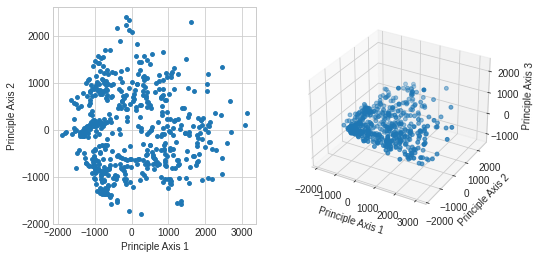

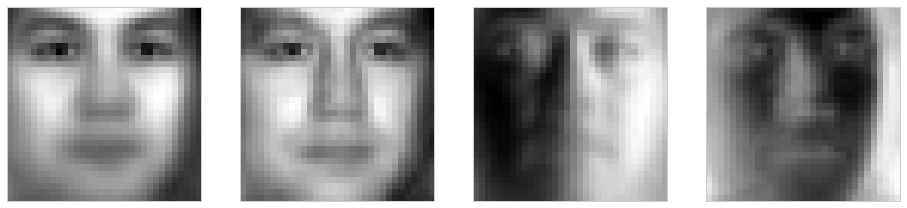

In [10]:
# Display Settings
plot_pca_result = True      # If we want to plot the PCA results
show_num_imgs = 5           # Number of example results to display after done, `0` for no output

# Set destination paths
data_path = '/home/ss/ss_ws/face-recognition/data'

# Read 500 images from the train set
PIE_train_imgs, my_train_imgs = readImageData(data_path, set='train', num_PIE_imgs=500)

# Stack image vectors together
PIE_train_imgs.extend(my_train_imgs)
X_train = np.vstack(PIE_train_imgs)
print(X_train.shape)

# Apply PCA on 2D and 3D
pca_2 = PCA(2)
proj_imgs_2d = pca_2.fit_transform(X_train)
pca_3 = PCA(3)
proj_imgs_3d = pca_3.fit_transform(X_train)

# Visualize data
if plot_pca_result:
    print('Visualizing Results... ')
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=plt.figaspect(0.5))
    c_map = plt.cm.get_cmap('jet', 10)
    # 2D subplot
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(proj_imgs_2d[:, 0], proj_imgs_2d[:, 1], s = 15, cmap = c_map)
    ax.set_xlabel('Principle Axis 1')
    ax.set_ylabel('Principle Axis 2')
    # 3D subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(proj_imgs_3d[:, 0], proj_imgs_3d[:, 1], proj_imgs_3d[:, 2], s = 15, cmap = c_map)
    ax.set_xlabel('Principle Axis 1')
    ax.set_ylabel('Principle Axis 2')
    ax.set_zlabel('Principle Axis 3')
    plt.show()

    # Plot the mean face and eigen faces
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
    ax.imshow(pca_3.mean_.reshape((32, 32)), cmap='gray')
    for i in range(3):
        ax = fig.add_subplot(1, 4, i + 2, xticks=[], yticks=[])
        ax.imshow(pca_3.components_[i].reshape((32, 32)), cmap='gray')
    plt.show()
    

(500, 200)
(500, 1024)
Showing 5 example results here


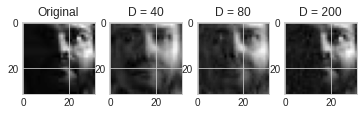

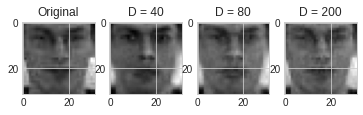

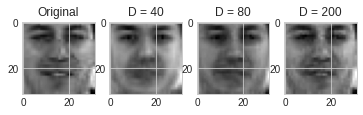

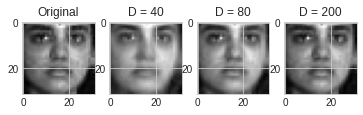

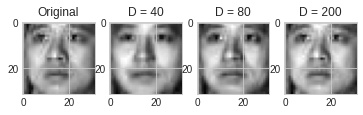

Finished PCA Processing


In [4]:
# Apply PCA with 40, 80, and 200 Dimensions
Dimensions = [40, 80, 200]
pca_list = []
proj_imgs_list = []
rec_imgs_list = []

for i in range(len(Dimensions)):
    pca_list.append(PCA(Dimensions[i]))
    # Fit PCA on the images
    proj_imgs_list.append(pca_list[i].fit_transform(X_train))
    # Reconstruct the images
    rec_imgs_list.append(pca_list[i].inverse_transform(proj_imgs_list[i]))

print(proj_imgs_list[2].shape)
print(rec_imgs_list[2].shape)

# Visualize reconstructed images
if show_num_imgs > 0:
    print('Showing %d example results here' % show_num_imgs)
    for i in range(X_train.shape[0]):
        if (i < show_num_imgs):
            fig, axs = plt.subplots(1, 4)
            axs[0].title.set_text('Original')
            axs[0].imshow(X_train[i, :].reshape((32, 32)), cmap='gray')
            axs[1].title.set_text('D = 40')
            axs[1].imshow(rec_imgs_list[0][i, :].reshape((32, 32)), cmap='gray')
            axs[2].title.set_text('D = 80')
            axs[2].imshow(rec_imgs_list[1][i, :].reshape((32, 32)), cmap='gray')
            axs[3].title.set_text('D = 200')
            axs[3].imshow(rec_imgs_list[2][i, :].reshape((32, 32)), cmap='gray')
            plt.show()
        else:
            break

print('Finished PCA Processing')